# Characterizing time-dependent error channels with Machine learning 
By combining dynamical decoupling, Ramsey measurements and machine learning we aim to seperate and characterize time-dependent error channels. 

The goal of this code is to demo a protocol for characterizing time-dependent Pauli error channels and distinguishing between them. We start by an example to distinguish between $x$ and $z$ errors on a qubit. For ion traps $x$ corresponds to laser amplitude fluctuations and $z$ to laser frequency drift. We apply dynamical decoupling $x,z$ gates to get the first and second (time-) integrals of the noise signals. 

Here we first demo the protocol up to first order in Dyson series (assuming F and G are small) because it leads to a nice formulae. However, this contains an error which is the sum of 2nd order terms in Dyson series and we will need to rotate the axis of DD gates to compensate for it. In order to do so we utilize ML algorithms (such as RNNs) to rotate the z axis in order to minimize the L1 norm between predicted and actual error signals (more late). This protocol could be adjusted to an experiment depending on whether the change in axis is done online or offline or a combination of them.

**Protocol**: 

Consider the Hamiltonian 

$$H(t) = f(t)X + g(t)Z $$

which includes both $X$ and $Z$ errors. Here, we utilize group-based decoupling design of bang-bang periodic decoupling pulses. In particular, we first apply the sequence corresponding to propagators $\{U_{g_k}\}_{k=0}^1 = \{I, X \}$,

$$\Big(XU_F(t_{N-2}, t_{N-1})X U_F(t_{N-3}, t_{N-2})\Big)\cdots \Big(XU(t_1, t_2) X U(t_0, t_1)\Big)$$

where $ U_F(	t_{i-1}, t_i)$ is unitary free evolution by the error Hamiltonian over the time interval $[t_{i-1}, t_i]$, considering discrete time steps $\{t_i\}_{i=0}^{N-1}$ s.t. $|t_{i+1} - t_i | \equiv \tau, \forall i$.

The total evolution can be written

$$
U_i = \prod_{i=1}^i X U_F(t_i - t_{i-1})
$$

Let $U_c(t)$ be the control propagator and define the control-modulated hamiltonian $\tilde{H} := U_c^\dag(t) H U_c(t)$. Then,

$$
U_2 = [XU(t_1, t_2) X U(t_0, t_1)](t) = U_c(t) \mathcal{T} \exp[-i \int_{t_0}^t dt' \tilde{H}(t')]
$$

where in this case $\tilde{H}(t') = \begin{cases} H(t'), & t' \in [t_0, t_1), t_2 \\
XH(t')X, &t' \in [t_1, t_2) \end{cases}$. If we assume that $U_c(t)$ is cyclic and $H(t)$ is periodic with intervals equivalent to the pulse lengths, then the toggle-frame Hamiltonian is then periodic as well. Therefore,

$$
U_2 = \mathcal{T}\exp[-i\sum_{j=0}^1\int_{t_j}^{t_{j+1}}(f(t) X + (-1)^j g(t) Z)dt]
$$

The first order term of the Magnus expansion is equivalent to assuming that the matrices in the exponent commute:

$$
U_2^{(0)}(t_0, t_0 + 2\tau) = \exp[- i \tau \sum_{j=0}^1\int_{t_j}^{t_{j+1}}(f(t) X + (-1)^j g(t) Z)dt]
$$


Similarly, the full sequence gives

$$
U_{N-1}^{(0)}(t_0, t_0 + N\tau) = \exp[-i \tau \sum_{j=0}^{N-1}\int_{t_j}^{t_{j+1}}(f(t) X + (-1)^j g(t) Z)dt], n \in \mathbb{N} \\
$$

Given our requirement of $f, g$ being periodic over pulse intervals in order to apply average Hamiltonian theory, the result simply depends on whether $g$ is odd or even: if $g$ is odd then we get $$U_{N-1}^{(0)}(t_0, t_0 + N\tau) = \exp[-i \tau \sum_{j=0}^{N-1}\int_{t_j}^{t_{j+1}}(f(t) X + g(t) Z)dt]$$ and if even $$U_{N-1}^{(0)}(t_0, t_0 + N\tau) = \exp[-i \tau \sum_{j=0}^{N-1}\int_{t_j}^{t_{j+1}}(f(t) X )dt]$$ 

### Example
Constant $f=f_0, g=g_0$. We then obtain

$$
U_{N-1}^{(0)}(t_0, t_0 + N\tau) = \exp[-i \tau \sum_{intervals} \int f_0X] \\
= \exp[-i N \tau f_0X]
$$
 
 Furthermore,
 
 
$$
H^{(1)} = \frac{-i}{2\tau} \int_0^{N\tau} dt'' \int_0^{t''} dt' [\tilde{H}(t''), \tilde{H}(t')]
$$

**Machine Learning**: Note that this result is valid only up to 1st order in Dysion series (first order in the max amplitude of channels). In an experiment, $\sigma_x$, $\sigma_z$ gates applied will themselves be rotated due to error channel (if e.g., they are applied with the same laser field) and furthermore the gates are not instantanous. These two will both lead to a second order (in amplidute) deviation from the theoretical result. And this is where we will use a machine learning algorithm (such as LSTM) to find the time-dependent correction to the axis orientation which compensates for both of the second order effects.

In [141]:
from qutip import *
import numpy as np
#import numpy.linalg
#from math import *
#from copy import copy
#from keras.models import Sequential
#from tensorflow import keras
#import tensorflow as tf
#import gym
#from gym import error, spaces, utils
#from gym.utils import seeding
#from scipy.special import mathieu_a
import matplotlib.pyplot as plt
#from operators import operators as ops
#from gym_simulation import *
import numpy as np
from scipy.optimize import minimize
from scipy import integrate

In [142]:
from numba import njit, jit
import numba

In [171]:
@jit
def get_states_optimized_helper(seqs):
    state = basis(2, 0)
    dd = identity(2)
    
    state_list = [state]
    
    i = 0
    for seq in seqs:
        state = seq * state
        if i % 2 == 0:
            state_list += [state]
        dd = seq * dd
        i+=1
        
    return state_list, dd
    
@jit
def get_states_optimized(N, ev: Evolution, tau):
    seqs = [ev.seq(i * tau, (i+1) * tau) for i in range(N)]
    return get_states_optimized_helper(seqs)

In [172]:
from enum import Enum
import types

class P(Enum):
    X = 1
    Y = 2
    Z = 3
    I = 4
    

class Pulse:
    def __init__(self, t: P):
        self.t = t
        self.op = sigmax()
        if t is  P.Y:
            self.op = sigmay()
        elif t is P.Z:
            self.op = sigmaz()
        elif t is P.I:
            self.op = identity(2)
            
    def __str__(self):
        return str(self.t)
    
class Noise:
    def __init__(self, f: types.LambdaType, g: types.LambdaType, h: types.LambdaType=None):
        self.X_fn = f
        self.Z_fn = g
        self.Y_fn = h
        
class Evolution:
    def __init__(self, p: Pulse, n: Noise, eps=1e-3):
        self.pulse = p
        self.noise = n
        
        self.eps = eps #Has to be less 1/cutoff_freq
        
        self.first_order_fn = n.X_fn
        if p.t is P.Z:
            self.first_order_fn = n.Z_fn
    
    def u(self, t_1, t_2):
        
        M = int((t_2-t_1)/self.eps )
        series = identity(2)
        
        _incremental_time_op = lambda t: (
            -1.j* self.eps * (self.noise.X_fn(t)*sigmax() + self.noise.Z_fn(t) * sigmaz())
        ).expm()

        for i in range(M+1):
            series *= _incremental_time_op(t_1 + i * self.eps)

        return series

    def seq(self, t_1, t_2):
        return self.pulse.op * self.u(t_1, t_2)
    
    def first_order_exp(self, t_final, t_0=0): 
    # find the first order exponential integral of a give Pauli operator
    
        return (  -1j * integrate.quad(self.first_order_fn, t_0, t_final)[0] * self.pulse.op).expm()
        


In [181]:
#Constant error channel H = f*x + g*z
tau = 0.0001
N = 1000
f = lambda t: 5.
g = lambda t: 0.05

x_ev = Evolution(
    Pulse(P.X),
    Noise(f, g))

z_ev = Evolution(
    Pulse(P.Z),
    Noise(f, g))

xx_state_list, xxDD = get_states_optimized(N, x_ev, tau)
zz_state_list, zzDD = get_states_optimized(N, z_ev, tau)

In [182]:
fo = x_ev.first_order_exp(N * tau, 0)
get_unitaries_diff_fidelity(xxDD, fo)

print(fo)
print(xxDD)

fidelity =  0.044434869673977806
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.87758256+0.j         0.        -0.47942554j]
 [0.        -0.47942554j 0.87758256+0.j        ]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 2.83662183e-01+0.j         -4.79466133e-05+0.95892427j]
 [ 4.79466133e-05+0.95892427j  2.83662183e-01+0.j        ]]


In [183]:
fo = z_ev.first_order_exp(N * tau, 0)
get_unitaries_diff_fidelity(zzDD, fo)

print(fo)
print(zzDD)

fidelity =  0.9979763789897547
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.9999875-0.00499998j 0.       +0.j        ]
 [0.       +0.j         0.9999875+0.00499998j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 9.98750271e-01-0.04997834j -2.49893765e-04+0.j        ]
 [ 2.49893765e-04+0.j          9.98750271e-01+0.04997834j]]


In [19]:
def get_unitaries_diff_proj(u, up=identity(2)):
    '''get projection of difference between two unitaries '''
    
    unitary_res = u @ np.array(up).transpose().conj() # should approach id
    
    for p, l in [(identity(2), 'id'), (sigmax(),'x'), (sigmay(),'y'), (sigmaz(),'z')]:
        print(l,
              np.array([np.matmul(unitary_res, b).trace() for b in [identity(2), sigmax(), sigmay(), sigmaz()] ])
             ) # trace dist
    
def get_unitaries_diff_fidelity(u,up=identity(2)):
    '''get projection of difference between two unitaries '''
    
    unitary_res = u @ np.array(up).transpose().conj()
    print( 'fidelity = ', ( np.abs(np.trace(unitary_res))/2)**2 )

In [84]:
def compute_complete_unitary(ev: Evolution, tau=0.0001):
        
    print("Compute "+ str(ev.pulse) + " Series")
    #rn = np.linspace(100, 1000000, 6, dtype=int)
    rn = [100]
    print(rn, "\n")

    for N in rn:
        print("N=", N)
        _, DD = get_states_optimized(N, ev, tau )

        fo = ev.first_order_exp(N * tau, 0)
        
        print("1st ord approx:\n", fo)
        print("true mat: \n", DD)
        get_unitaries_diff_fidelity(DD, fo)
        get_unitaries_diff_proj(DD, fo)
        print("\n\n")

In [85]:
f,g = lambda t: np.sin(5.5*t), lambda t: np.cos(11.*t)

x_ev = Evolution(
    Pulse(P.X),
    Noise(f, g))

z_ev = Evolution(
    Pulse(P.Z),
    Noise(f, g))


compute_complete_unitary(x_ev)

compute_complete_unitary(z_ev)


Compute P.X Series
[100] 

N= 100
1st ord approx:
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.99999996+0.j         0.        -0.00027493j]
 [0.        -0.00027493j 0.99999996+0.j        ]]
true mat: 
 [[ 9.99996296e-01-2.99175041e-06j  2.71367499e-06-2.72181547e-03j]
 [-2.71367499e-06-2.72181547e-03j  9.99996296e-01+2.99175041e-06j]]
fidelity =  0.9999940127340406
id [ 1.99999401e+00-1.95241094e-18j -8.89384595e-21-4.89377141e-03j
 -5.63785130e-18+5.42899482e-06j  2.55351296e-15-5.98200845e-06j]
x [ 1.99999401e+00-1.95241094e-18j -8.89384595e-21-4.89377141e-03j
 -5.63785130e-18+5.42899482e-06j  2.55351296e-15-5.98200845e-06j]
y [ 1.99999401e+00-1.95241094e-18j -8.89384595e-21-4.89377141e-03j
 -5.63785130e-18+5.42899482e-06j  2.55351296e-15-5.98200845e-06j]
z [ 1.99999401e+00-1.95241094e-18j -8.89384595e-21-4.89377141e-03j
 -5.63785130e-18+5.42899482e-06j  2.55351296e-15-5.98200845e-06j]



Compute P.Z Series
[100] 

N= 100
1st ord app

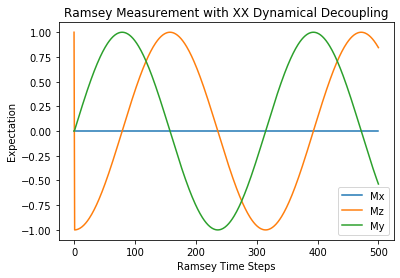

In [176]:
plt.figure()


dx = expect(sigmax(), xx_state_list)
plt.plot(dx , label='Mx')
plt.plot(expect(sigmaz(), xx_state_list) , label='Mz')
plt.plot(expect(sigmay(), xx_state_list) , label='My')

plt.xlabel("Ramsey Time Steps")
plt.ylabel("Expectation")

plt.legend()

plt.title("Ramsey Measurement with XX Dynamical Decoupling")

plt.show()

__We perform Quantum process tomography at the end of the gate sequence in order to find first and second order integrals of the signal:__

$$
\epsilon(\rho) = \sum_{m, n} \chi_{m,n}E_m \rho E_n^\dag
$$

In [119]:
def get_chi(U_psi):
    # create a superoperator for the density matrix

    U_rho = spre(U_psi) * spost(U_psi.dag()) # conjugation by U_psi
    # operator basis for the process tomography
    op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
    # calculate the chi matrix
    chi = qpt(U_rho, op_basis)
    
    return chi

def plt_qpt_gate(U_psi, name, figsize=(8,6)):
    
    chi = get_chi(U_psi)
    op_label = [["$i$", "$x$", "$y$", "$z$"]]

    # visualize the chi matrix
    fig, ax = qpt_plot_combined(chi, op_label, name, figsize=figsize)
    ax.set_title(name)
    
    return chi, fig, ax

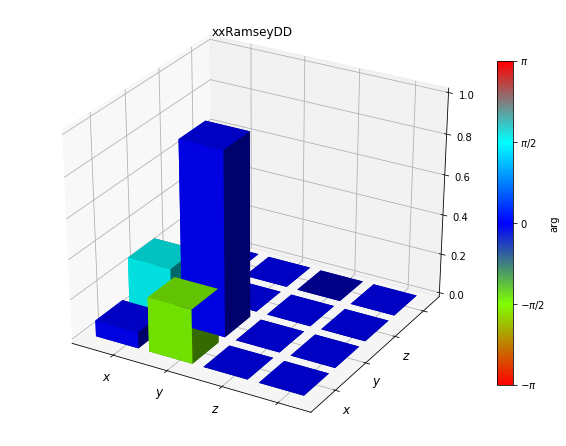

In [120]:
# plot the chi matrix
chi_xxDD = plt_qpt_gate(xxDD, "xxRamseyDD")[0]


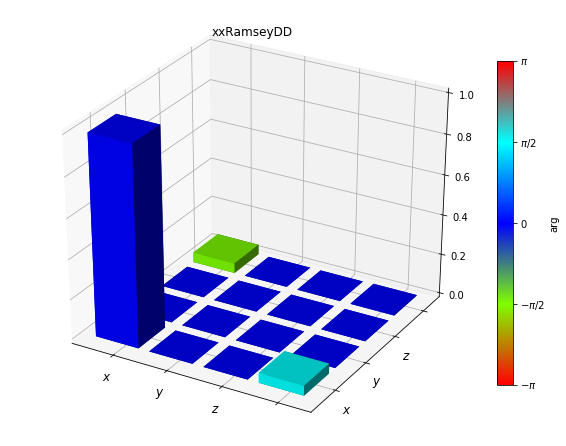

In [121]:
chi_zzDD = plt_qpt_gate(zzDD, "xxRamseyDD")[0]

In [122]:
#Time-evolution operators 
U_rot = lambda r: (-1.j*(r[0]*sigmax()+r[1]*sigmay()+r[2]*sigmaz())).expm()
#Now rotation with a gauge r[3]
U_rot_gauge = lambda r: (-1.j*(r[0]*sigmax()+r[1]*sigmay()+r[2]*sigmaz())).expm() * np.exp(-1.j*r[3])

In [123]:
#Optimize for the gauge 
def chi_err(r, chi_measurement=chi_xxDD):
    U_psi = U_rot(r)
    return np.sum(np.abs(get_chi(U_psi)-chi_measurement)**2)
#Optimization with gauge altogether (timely)

def gauge_optimize(r0):
    res = minimize(chi_err, r0, method='nelder-mead',
                   options={'xtol': 1e-8, 'disp': True})
    return res.x
        
        
res_x = gauge_optimize(
    np.array([1., .1, .5])
)

true_val = [N * tau * f % np.pi, 0., 0.]

print("fit: ", res_x)
print("first ord: ", true_val)
print("l2 dist: ", np.linalg.norm(res_x - true_val))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 247
fit:  [ 1.85840734e+00 -9.29548686e-06  1.60498621e-10]
first ord:  [1.8584073464102069, 0.0, 0.0]
l2 dist:  9.295487002442205e-06


Consider $f = \sin(2\pi x / T), g = g_0$ for some constant $T$.

Then, $\int_{t_i}^{t_{i+1}} fdt = [-\cos(2\pi x / T)]_{t_i}^{t_{i+1}}$

In [124]:
tau = 0.0001
N = 10000

T = 1.01 * tau # if T= tau, f is odd => pulse averages out to id
I_f = lambda t_1, t_2, T: np.cos(2 * np.pi * t_1 / T) - np.cos(2 * np.pi * t_2 / T) 
I_g = g * tau


U_dyn = lambda t_1, t_2, T: (-1.j*(I_f(t_1, t_2, T) * sigmax() + I_g * sigmaz())).expm()

In [125]:
def get_states_dynamic(N, pulse, T):
    state_list = []
    state = basis(2, 0)
    dd = identity(2)
    
    for i in range(N):
        seq = pulse * U_dyn(i * tau, (i+1) * tau, T)
        state = seq * state
        if i % 2 == 0:
            state_list += [state]
        dd = seq * dd
    
    return state_list, dd

In [126]:
xx_state_list, xxDD = get_states_dynamic(N, sigmax(), T)
zz_state_list, zzDD = get_states_dynamic(N, sigmaz(), T)

In [127]:
first_order_exp = (
            -1j * np.sum([I_f(i * tau, (i+1) * tau, T) for i in range (N)]) * sigmax()
                ).expm()
print("1st ord approx:\n", first_order_exp)
print("true mat: \n", xxDD)
get_unitaries_diff_fidelity(xxDD, first_order_exp)
get_unitaries_diff_proj(xxDD, first_order_exp)

1st ord approx:
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.99999813+0.j        0.        -0.0019344j]
 [0.        -0.0019344j 0.99999813+0.j       ]]
true mat: 
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 9.99998129e-01+1.24833061e-11j  9.67199622e-09-1.93440166e-03j]
 [-9.67199622e-09-1.93440166e-03j  9.99998129e-01-1.24833061e-11j]]
fidelity =  0.9999999999998503
id [ 2.00000000e+00-1.10113378e-20j  5.79026429e-23+6.51471065e-14j
  2.25514052e-17+1.93439079e-08j -5.99520433e-15+6.23856166e-11j]
x [ 2.00000000e+00-1.10113378e-20j  5.79026429e-23+6.51471065e-14j
  2.25514052e-17+1.93439079e-08j -5.99520433e-15+6.23856166e-11j]
y [ 2.00000000e+00-1.10113378e-20j  5.79026429e-23+6.51471065e-14j
  2.25514052e-17+1.93439079e-08j -5.99520433e-15+6.23856166e-11j]
z [ 2.00000000e+00-1.10113378e-20j  5.79026429e-23+6.51471065e-14j
  2.25514052e-17+1.93439079e-08j -5.99520433e-15+6.23856166e-

In [ ]:
for T in np.linspace(1.0, 5.0, 11): # period of f(t)
    print("T: ", T, "\n")
    xx_state_list, xxDD = get_states_dynamic(N, sigmax(), T)
    first_order_exp = (
            -1j * np.sum([I_f(i * tau, (i+1) * tau, T) for i in range (N)]) * sigmax()
                ).expm()
    
    print("1st ord approx:\n", first_order_exp)
    print("true mat: \n", xxDD)
    get_unitaries_diff_fidelity(xxDD, first_order_exp)
    get_unitaries_diff_proj(xxDD, first_order_exp)
    print("\n\n")

T:  1.0 

1st ord approx:
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
true mat: 
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
fidelity =  1.000000000001311
id [ 2.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -6.66133815e-16+0.j]
x [ 2.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -6.66133815e-16+0.j]
y [ 2.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -6.66133815e-16+0.j]
z [ 2.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -6.66133815e-16+0.j]



T:  1.4 

1st ord approx:
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.34127725+0.j         0.        -0.93996268j]
 [0.        -0.93996268j 0.34127725+0.j        ]]
true mat: 
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 3.41277249e-01+0.j          4.69981370e-06-0.9

Consider $f = \sin(2\pi x / T_1), g = \sin(2\pi x / T_2)$ for some constants $T_1, T_2$.

Then, $\int_{t_i}^{t_{i+1}} fdt = [-\cos(2\pi x / T)]_{t_i}^{t_{i+1}}$ and similarly for $g$.

If $T_2 >> \tau$, then adjacent integrations are approximately equal and so the the $(-1)^j$ modulated integration of $g$ goes to zero.

In [101]:
tau = 0.0001
N = 10000

T1 = 1.05 * tau # if T= tau, f is odd => pulse averages out to id
T2 = 10 * tau

I_f = I_g = lambda t_1, t_2, T: np.cos(2 * np.pi * t_1 / T) - np.cos(2 * np.pi * t_2 / T) 

U_dyn = lambda t_1, t_2, T1, T2: (-1.j*(I_f(t_1, t_2, T1) * sigmax() + I_g(t_1, t_2, T2) * sigmaz())).expm()

In [ ]:
T1 = 1.05 * tau # if T= tau, f is odd => pulse averages out to id
T2 = 10 * tau

f = lambda t: np.sin(2 * np.pi * t / T1) 
g = lambda t: np.sin(2 * np.pi * t / T2) 

x_ev = Evolution(
    Pulse(P.X),
    Noise(f, g))

z_ev = Evolution(
    Pulse(P.Z),
    Noise(f, g))


compute_complete_unitary(x_ev)

compute_complete_unitary(z_ev)


In [102]:
def get_states_dynamic(N, pulse, T1, T2):
    state_list = []
    state = basis(2, 0)
    dd = identity(2)
    
    for i in range(N):
        seq = pulse * U_dyn(i * tau, (i+1) * tau, T1, T2)
        state = seq * state
        if i % 2 == 0:
            state_list += [state]
        dd = seq * dd
    
    return state_list, dd

In [104]:
for T2 in np.linspace(1.0, 10.0, 11): # period of f(t) relative to tau:
    T2 *= tau
    print("T2: ", T2, "\n")
    
    xx_state_list, xxDD = get_states_dynamic(N, sigmax(), T1, T2)
    zz_state_list, zzDD = get_states_dynamic(N, sigmaz(), T1, T2)
    
    first_order_exp = (
            -1j * ( np.sum([I_f(i * tau, (i+1) * tau, T1) for i in range (N)]) * sigmax()
                   + np.sum([(-1) ** i * I_g(i * tau, (i+1) * tau, T2) for i in range (N)]) * sigmaz()
                  )
                ).expm()

    first_order_exp_slow_varying = (
                -1j * ( np.sum([I_f(i * tau, (i+1) * tau, T1) for i in range (N)]) * sigmax()
                      )
                    ).expm() # valid only if g(t) is slow-varying relative to the pulse frequency

    print("1st ord approx:\n", first_order_exp)
    print("true mat: \n", xxDD)
    get_unitaries_diff_fidelity(xxDD, first_order_exp)
    get_unitaries_diff_proj(xxDD, first_order_exp)

    print("\n")

    print("1st ord approx for slow varying:\n", first_order_exp_slow_varying)
    print("true mat: \n", xxDD)
    get_unitaries_diff_fidelity(xxDD, first_order_exp_slow_varying)
    get_unitaries_diff_proj(xxDD, first_order_exp_slow_varying)
    
    print("\n\n")

T2:  0.0001 

1st ord approx:
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.80527394+0.j         0.        -0.59290293j]
 [0.        -0.59290293j 0.80527394+0.j        ]]
true mat: 
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.80527394+0.j         0.        -0.59290293j]
 [0.        -0.59290293j 0.80527394+0.j        ]]
fidelity =  1.0000000000000036
id [ 2.00000000e+00+0.00000000e+00j  0.00000000e+00+5.55111512e-16j
 -1.11022302e-15+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
x [ 2.00000000e+00+0.00000000e+00j  0.00000000e+00+5.55111512e-16j
 -1.11022302e-15+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
y [ 2.00000000e+00+0.00000000e+00j  0.00000000e+00+5.55111512e-16j
 -1.11022302e-15+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
z [ 2.00000000e+00+0.00000000e+00j  0.00000000e+00+5.55111512e-16j
 -1.11022302e-15+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


1st ord app

In [80]:
pwd

'/home/trxw/Documents/ML/rl-quantum-gates/ml-q-channel-cpcp/ml-q-channel'